In [1]:
import random
random.seed(3883)
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
pd.options.display.max_rows = 2000
pd.options.display.max_columns = 1000

/Users/lama/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# reading Admissions dataset 
# data was in .Rdata format so it was loaded into R and saved to csv format
df = pd.read_csv("admission_data.csv")
df.head()

,dep_name,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,insurance_status,disposition,arrivalmode,arrivalmonth,arrivalday,arrivalhour_bin,previousdispo,2ndarymalig,abdomhernia,abdomnlpain,abortcompl,acqfootdef,acrenlfail,acutecvd,acutemi,acutphanm,adjustmentdisorders,adltrespfl,alcoholrelateddisorders,allergy,amniosdx,analrectal,anemia,aneurysm,anxietydisorders,appendicitis,artembolism,asppneumon,asthma,attentiondeficitconductdisruptivebeha,backproblem,biliarydx,birthasphyx,birthtrauma,bladdercncr,blindness,bnignutneo,bonectcncr,bph,brainnscan,breastcancr,breastdx,brnchlngca,bronchitis,burns,cardiaarrst,cardiacanom,carditis,cataract,cervixcancr,chestpain,chfnonhp,chrkidneydisease,coaghemrdx,coloncancer,comabrndmg,complicdevi,complicproc,conduction,contraceptiv,copd,coronathero,crushinjury,cysticfibro,deliriumdementiaamnesticothercognitiv,developmentaldisorders,diabmelnoc,diabmelwcm,disordersusuallydiagnosedininfancych,diverticulos,dizziness,dminpreg,dysrhythmia,earlylabor,ecodesadverseeffectsofmedicalcare,ecodesadverseeffectsofmedicaldrugs,ecodescutpierce,ecodesdrowningsubmersion,ecodesfall,ecodesfirearm,ecodesfireburn,ecodesmachinery,ecodesmotorvehicletrafficmvt,ecodesnaturalenvironment,ecodesotherspecifiedandclassifiable,ecodesotherspecifiednec,ecodespedalcyclistnotmvt,ecodesplaceofoccurrence,ecodespoisoning,ecodesstruckbyagainst,ecodessuffocation,ecodestransportnotmvt,ecodesunspecified,ectopicpreg,encephalitis,endometrios,epilepsycnv,esophcancer,esophgealdx,exameval,eyeinfectn,fatigue,femgenitca,feminfertil,fetaldistrs,fluidelcdx,fuo,fxarm,fxhip,fxleg,fxskullfac,gangrene,gasduoulcer,gastritis,gastroent,giconganom,gihemorrhag,giperitcan,glaucoma,goutotcrys,guconganom,hdnckcancr,headachemig,hemmorhoids,hemorrpreg,hepatitis,hivinfectn,hodgkinsds,hrtvalvedx,htn,htncomplicn,htninpreg,hyperlipidem,immunitydx,immunizscrn,impulsecontroldisordersnec,inducabortn,infectarth,influenza,infmalegen,intestinfct,intobstruct,intracrninj,jointinjury,kidnyrnlca,lateeffcvd,leukemias,liveborn,liveribdca,longpregncy,lowbirthwt,lungexternl,lymphenlarg,maintchemr,malgenitca,maligneopls,malposition,meningitis,menopausldx,menstrualdx,miscellaneousmentalhealthdisorders,mooddisorders,mouthdx,ms,multmyeloma,mycoses,nauseavomit,neoplsmunsp,nephritis,nervcongan,nonepithca,nonhodglym,nutritdefic,obrelatedperintrauma,opnwndextr,opnwndhead,osteoarthros,osteoporosis,otacqdefor,otaftercare,otbnignneo,otbonedx,otcirculdx,otcomplbir,otconganom,otconntiss,otdxbladdr,otdxkidney,otdxstomch,otendodsor,otfemalgen,othbactinf,othcnsinfx,othematldx,othercvd,othereardx,otheredcns,othereyedx,othergidx,othergudx,otherinjury,otherpregnancyanddeliveryincludingnormal,otherscreen,othfracture,othheartdx,othinfectns,othliverdx,othlowresp,othmalegen,othnervdx,othskindx,othveindx,otinflskin,otitismedia,otjointdx,otnutritdx,otperintdx,otpregcomp,otprimryca,otrespirca,otupprresp,otuprspin,ovariancyst,ovarycancer,pancreascan,pancreasdx,paralysis,parkinsons,pathologfx,pelvicobstr,perintjaund,peripathero,peritonitis,personalitydisorders,phlebitis,pid,pleurisy,pneumonia,poisnnonmed,poisnotmed,poisonpsych,precereoccl,prevcsectn,prolapse,prostatecan,pulmhartdx,rctmanusca,rehab,respdistres,retinaldx,rheumarth,schizophreniaandotherpsychoticdisorde,screeningandhistoryofmentalhealthan,septicemia,septicemiaexceptinlabor,sexualinfxs,shock,sicklecell,skininfectn,skinmelanom,sle,socialadmin,spincorinj,spontabortn,sprain,stomchcancr,substancerelateddisorders,suicideandintentionalselfinflictedin,superficinj,syncope,teethdx,testiscancr,thyroidcncr,thyroiddsor,tia,tonsillitis,tuberculosis,ulceratcol,ulcerskin,umbilcord,unclassified,urinstone,urinyorgca,uteruscancr,uti,varicosevn,viralinfect,whtblooddx,n_edvisits,n_admissions,absolutelymphocytecount_last,acetonebld_last,alanineaminotransferase(alt)_last,albumin_last,alkphos_last,anc(absneutrophilcount)_last,aniongap_last,aspartateaminotransferase(ast)_last,"b-typenatriureticpeptide,pro(probnp)_last",baseexcess(poc)_last,"baseex

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560486 entries, 0 to 560485
Columns: 972 entries, dep_name to cc_wristpain
dtypes: float64(589), int64(368), object(15)
memory usage: 4.1+ GB


In [ ]:
# Assess missing values of dataset
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
missing_values_table(df)

In [ ]:
count = 0
for column in df:
    if df[column].isnull().mean() > 0.3:
        print('{0} has {1} null values'.format(column, df[column].isnull().sum()))
        count = count + 1
print('total is {0} columns.'.format(count))

In [55]:
df.disposition.value_counts()

Discharge    393848
Admit        166638
Name: disposition, dtype: int64

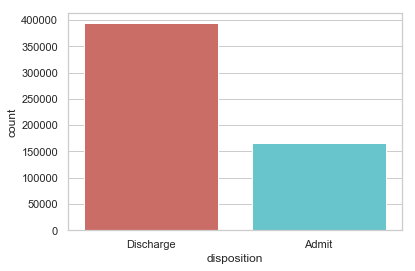

In [56]:
# DATA VISUALIZATION
# Exploing our target : disposition
sns.countplot(x='disposition', data = df, palette= 'hls')
plt.show()

In [57]:
count_discharge = len(df[df['disposition']=="Discharge"])
count_admit = len(df[df['disposition']=="Admit"])
pct_of_admit = count_admit/(count_admit+count_discharge)
print("percentage of Admission is", pct_of_admit*100)

percentage of Admission is 29.730983467918914


In [58]:
df.groupby("disposition").mean()

,esi,age,2ndarymalig,abdomhernia,abdomnlpain,abortcompl,acqfootdef,acrenlfail,acutecvd,acutemi,acutphanm,adjustmentdisorders,adltrespfl,alcoholrelateddisorders,allergy,amniosdx,analrectal,anemia,aneurysm,anxietydisorders,appendicitis,artembolism,asppneumon,asthma,attentiondeficitconductdisruptivebeha,backproblem,biliarydx,birthasphyx,birthtrauma,bladdercncr,blindness,bnignutneo,bonectcncr,bph,brainnscan,breastcancr,breastdx,brnchlngca,bronchitis,burns,cardiaarrst,cardiacanom,carditis,cataract,cervixcancr,chestpain,chfnonhp,chrkidneydisease,coaghemrdx,coloncancer,comabrndmg,complicdevi,complicproc,conduction,contraceptiv,copd,coronathero,crushinjury,cysticfibro,deliriumdementiaamnesticothercognitiv,developmentaldisorders,diabmelnoc,diabmelwcm,disordersusuallydiagnosedininfancych,diverticulos,dizziness,dminpreg,dysrhythmia,earlylabor,ecodesadverseeffectsofmedicalcare,ecodesadverseeffectsofmedicaldrugs,ecodescutpierce,ecodesdrowningsubmersion,ecodesfall,ecodesfirearm,ecodesfireburn,ecodesmachinery,ecodesmotorvehicletrafficmvt,ecodesnaturalenvironment,ecodesotherspecifiedandclassifiable,ecodesotherspecifiednec,ecodespedalcyclistnotmvt,ecodesplaceofoccurrence,ecodespoisoning,ecodesstruckbyagainst,ecodessuffocation,ecodestransportnotmvt,ecodesunspecified,ectopicpreg,encephalitis,endometrios,epilepsycnv,esophcancer,esophgealdx,exameval,eyeinfectn,fatigue,femgenitca,feminfertil,fetaldistrs,fluidelcdx,fuo,fxarm,fxhip,fxleg,fxskullfac,gangrene,gasduoulcer,gastritis,gastroent,giconganom,gihemorrhag,giperitcan,glaucoma,goutotcrys,guconganom,hdnckcancr,headachemig,hemmorhoids,hemorrpreg,hepatitis,hivinfectn,hodgkinsds,hrtvalvedx,htn,htncomplicn,htninpreg,hyperlipidem,immunitydx,immunizscrn,impulsecontroldisordersnec,inducabortn,infectarth,influenza,infmalegen,intestinfct,intobstruct,intracrninj,jointinjury,kidnyrnlca,lateeffcvd,leukemias,liveborn,liveribdca,longpregncy,lowbirthwt,lungexternl,lymphenlarg,maintchemr,malgenitca,maligneopls,malposition,meningitis,menopausldx,menstrualdx,miscellaneousmentalhealthdisorders,mooddisorders,mouthdx,ms,multmyeloma,mycoses,nauseavomit,neoplsmunsp,nephritis,nervcongan,nonepithca,nonhodglym,nutritdefic,obrelatedperintrauma,opnwndextr,opnwndhead,osteoarthros,osteoporosis,otacqdefor,otaftercare,otbnignneo,otbonedx,otcirculdx,otcomplbir,otconganom,otconntiss,otdxbladdr,otdxkidney,otdxstomch,otendodsor,otfemalgen,othbactinf,othcnsinfx,othematldx,othercvd,othereardx,otheredcns,othereyedx,othergidx,othergudx,otherinjury,otherpregnancyanddeliveryincludingnormal,otherscreen,othfracture,othheartdx,othinfectns,othliverdx,othlowresp,othmalegen,othnervdx,othskindx,othveindx,otinflskin,otitismedia,otjointdx,otnutritdx,otperintdx,otpregcomp,otprimryca,otrespirca,otupprresp,otuprspin,ovariancyst,ovarycancer,pancreascan,pancreasdx,paralysis,parkinsons,pathologfx,pelvicobstr,perintjaund,peripathero,peritonitis,personalitydisorders,phlebitis,pid,pleurisy,pneumonia,poisnnonmed,poisnotmed,poisonpsych,precereoccl,prevcsectn,prolapse,prostatecan,pulmhartdx,rctmanusca,rehab,respdistres,retinaldx,rheumarth,schizophreniaandotherpsychoticdisorde,screeningandhistoryofmentalhealthan,septicemia,septicemiaexceptinlabor,sexualinfxs,shock,sicklecell,skininfectn,skinmelanom,sle,socialadmin,spincorinj,spontabortn,sprain,stomchcancr,substancerelateddisorders,suicideandintentionalselfinflictedin,superficinj,syncope,teethdx,testiscancr,thyroidcncr,thyroiddsor,tia,tonsillitis,tuberculosis,ulceratcol,ulcerskin,umbilcord,unclassified,urinstone,urinyorgca,uteruscancr,uti,varicosevn,viralinfect,whtblooddx,n_edvisits,n_admissions,absolutelymphocytecount_last,acetonebld_last,alanineaminotransferase(alt)_last,albumin_last,alkphos_last,anc(absneutrophilcount)_last,aniongap_last,aspartateaminotransferase(ast)_last,"b-typenatriureticpeptide,pro(probnp)_last",baseexcess(poc)_last,"baseexcess,venous(poc)_last",basos_last,basosabs_last,"benzodiazepinesscreen,urine,noconf._last",bilirubindirect_last,bilirubintotal_last,bun_last,bun/creatratio_last,calciu

In [ ]:
# Observation: Averge Age for admission is higher than for discharge.

In [59]:
# Explore Triage level information
df["esi"].value_counts()

3.0    236229
2.0    163534
4.0    125003
5.0     27992
1.0      5271
Name: esi, dtype: int64

In [1]:
sns.catplot(x="esi", kind="count", palette="ch:.25", data=df);

NameError: name 'sns' is not defined

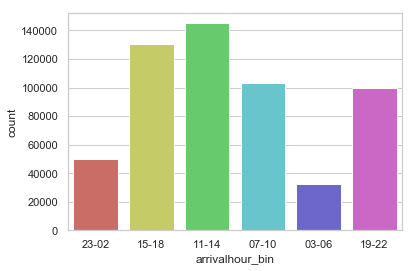

In [60]:
# Explore visits by hour
sns.countplot(x='arrivalhour_bin', data = df, palette= 'hls')
plt.show()

In [4]:
# Mapping the target variable to 0,1
df['disposition'] = df['disposition'].map({'Admit': 1, 'Discharge': 0})

In [5]:
# MISSING VALUES
# 1- Dropping columns where missing values exceeds 30% of its values.
df = df[df.columns[df.isnull().mean() < 0.3]]
df.shape

(560486, 588)

In [6]:
# 2- Imputation for missing values 
# Seperate columns for imputation
categorical_list = []
numerical_list = []
for i in df.columns.tolist():
    if df[i].dtype=='object':
        categorical_list.append(i)
    else:
        numerical_list.append(i)
print('Number of categorical features:', str(len(categorical_list)))
print('Number of numerical features:', str(len(numerical_list)))

Number of categorical features: 14
Number of numerical features: 574


In [7]:
# Replace missing numerical values with median
from sklearn.preprocessing import Imputer
df[numerical_list] = Imputer(strategy='median').fit_transform(df[numerical_list])

In [8]:
# Replace missing categorical values with most common value
for i in categorical_list:
    most_common = df[i].value_counts().index[0]
    df[i] = df[i].fillna(most_common)

In [ ]:
missing_values_table(df)

In [32]:
df2 = pd.get_dummies(df)

In [33]:
df2.to_csv("AdmissionDataImputed.csv")

In [9]:
# Defining X,Y
X = df.loc[:, df.columns != 'disposition']
y = df.loc[:, df.columns == 'disposition']

In [10]:
# FACTORIZING : DUMMIFY CATEGORICAL COLUMNS
X = pd.get_dummies(X)

In [41]:
# SPLITTING DATA : into train, test with 7:3 ratio
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=0)

In [15]:
X_train.to_csv("adm_xtrain.csv")
y_train.to_csv("adm_ytrain.csv")

,esi,age,2ndarymalig,abdomhernia,abdomnlpain,abortcompl,acqfootdef,acrenlfail,acutecvd,acutemi,acutphanm,adjustmentdisorders,adltrespfl,alcoholrelateddisorders,allergy,amniosdx,analrectal,anemia,aneurysm,anxietydisorders,appendicitis,artembolism,asppneumon,asthma,attentiondeficitconductdisruptivebeha,backproblem,biliarydx,birthasphyx,birthtrauma,bladdercncr,blindness,bnignutneo,bonectcncr,bph,brainnscan,breastcancr,breastdx,brnchlngca,bronchitis,burns,cardiaarrst,cardiacanom,carditis,cataract,cervixcancr,chestpain,chfnonhp,chrkidneydisease,coaghemrdx,coloncancer,comabrndmg,complicdevi,complicproc,conduction,contraceptiv,copd,coronathero,crushinjury,cysticfibro,deliriumdementiaamnesticothercognitiv,developmentaldisorders,diabmelnoc,diabmelwcm,disordersusuallydiagnosedininfancych,diverticulos,dizziness,dminpreg,dysrhythmia,earlylabor,ecodesadverseeffectsofmedicalcare,ecodesadverseeffectsofmedicaldrugs,ecodescutpierce,ecodesdrowningsubmersion,ecodesfall,ecodesfirearm,ecodesfireburn,ecodesmachinery,ecodesmotorvehicletrafficmvt,ecodesnaturalenvironment,ecodesotherspecifiedandclassifiable,ecodesotherspecifiednec,ecodespedalcyclistnotmvt,ecodesplaceofoccurrence,ecodespoisoning,ecodesstruckbyagainst,ecodessuffocation,ecodestransportnotmvt,ecodesunspecified,ectopicpreg,encephalitis,endometrios,epilepsycnv,esophcancer,esophgealdx,exameval,eyeinfectn,fatigue,femgenitca,feminfertil,fetaldistrs,fluidelcdx,fuo,fxarm,fxhip,fxleg,fxskullfac,gangrene,gasduoulcer,gastritis,gastroent,giconganom,gihemorrhag,giperitcan,glaucoma,goutotcrys,guconganom,hdnckcancr,headachemig,hemmorhoids,hemorrpreg,hepatitis,hivinfectn,hodgkinsds,hrtvalvedx,htn,htncomplicn,htninpreg,hyperlipidem,immunitydx,immunizscrn,impulsecontroldisordersnec,inducabortn,infectarth,influenza,infmalegen,intestinfct,intobstruct,intracrninj,jointinjury,kidnyrnlca,lateeffcvd,leukemias,liveborn,liveribdca,longpregncy,lowbirthwt,lungexternl,lymphenlarg,maintchemr,malgenitca,maligneopls,malposition,meningitis,menopausldx,menstrualdx,miscellaneousmentalhealthdisorders,mooddisorders,mouthdx,ms,multmyeloma,mycoses,nauseavomit,neoplsmunsp,nephritis,nervcongan,nonepithca,nonhodglym,nutritdefic,obrelatedperintrauma,opnwndextr,opnwndhead,osteoarthros,osteoporosis,otacqdefor,otaftercare,otbnignneo,otbonedx,otcirculdx,otcomplbir,otconganom,otconntiss,otdxbladdr,otdxkidney,otdxstomch,otendodsor,otfemalgen,othbactinf,othcnsinfx,othematldx,othercvd,othereardx,otheredcns,othereyedx,othergidx,othergudx,otherinjury,otherpregnancyanddeliveryincludingnormal,otherscreen,othfracture,othheartdx,othinfectns,othliverdx,othlowresp,othmalegen,othnervdx,othskindx,othveindx,otinflskin,otitismedia,otjointdx,otnutritdx,otperintdx,otpregcomp,otprimryca,otrespirca,otupprresp,otuprspin,ovariancyst,ovarycancer,pancreascan,pancreasdx,paralysis,parkinsons,pathologfx,pelvicobstr,perintjaund,peripathero,peritonitis,personalitydisorders,phlebitis,pid,pleurisy,pneumonia,poisnnonmed,poisnotmed,poisonpsych,precereoccl,prevcsectn,prolapse,prostatecan,pulmhartdx,rctmanusca,rehab,respdistres,retinaldx,rheumarth,schizophreniaandotherpsychoticdisorde,screeningandhistoryofmentalhealthan,septicemia,septicemiaexceptinlabor,sexualinfxs,shock,sicklecell,skininfectn,skinmelanom,sle,socialadmin,spincorinj,spontabortn,sprain,stomchcancr,substancerelateddisorders,suicideandintentionalselfinflictedin,superficinj,syncope,teethdx,testiscancr,thyroidcncr,thyroiddsor,tia,tonsillitis,tuberculosis,ulceratcol,ulcerskin,umbilcord,unclassified,urinstone,urinyorgca,uteruscancr,uti,varicosevn,viralinfect,whtblooddx,n_edvisits,n_admissions,bloodua_last,glucoseua_last,ketonesua_last,leukocytesua_last,nitriteua_last,pregtestur_last,proteinua_last,"bloodculture,routine_last","urineculture,routine_last",bloodua_npos,glucoseua_npos,ketonesua_npos,leukocytesua_npos,nitriteua_npos,pregtestur_npos,proteinua_npos,"bloodculture,routine_npos","urineculture,routine_npos",bloodua_count,glucoseua_count,ketonesua_count,leukocytesua_count,nitriteua_count,pregtestur_count

In [42]:
# FEATURE SELECTION: tried 2 ways  
# 1- Feature Importance
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(X_train, y_train.values.ravel())
# display the relative importance of each attribute
print(model.feature_importances_)

[1.57970565e-01 1.30182616e-03 1.39939332e-03 6.88905386e-04
 6.51496310e-04 3.62954693e-04 4.68731511e-04 1.81521815e-03
 1.44223345e-03 9.03292521e-04 1.49336993e-03 7.46001043e-04
 7.86744203e-04 4.62114734e-03 2.61725211e-03 1.24284678e-03
 3.39294939e-03 3.57045662e-04 5.63465312e-02 2.34677951e-02
 1.19544165e-02 1.38950562e-02 4.54708184e-04 2.66557513e-02
 6.20672443e-03 2.74162765e-02 4.39301394e-03 7.54445594e-03
 1.84696820e-04 2.22364458e-02 6.72208260e-02 3.06509695e-03
 4.58030351e-02 1.20835145e-02 2.69256740e-03 2.93365488e-05
 1.22660859e-03 4.47359770e-02 1.41970311e-03 2.45994602e-02
 1.91894249e-02 4.46441136e-02 3.13059630e-04 6.99377622e-04
 9.38214100e-03 5.94738904e-04 4.31136887e-03 9.12234382e-04
 5.24136896e-04 5.46518100e-04 1.37404546e-02 1.69162804e-03
 1.82331632e-03 6.53407339e-03 1.82388459e-03 2.51631759e-04
 4.79749710e-04 1.01758553e-03 1.88746051e-04 2.19187983e-03
 1.45430199e-04 4.31928868e-04 1.90225642e-04 4.16279846e-04
 8.57996376e-04 8.115320

In [43]:
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',                                                                 ascending=False)

In [44]:
feature_importances

,importance
esi,0.157971
arrivalmode_ambulance,0.074589
meds_cardiovascular,0.067221
previousdispo_Admit,0.057288
meds_analgesics,0.056347
meds_diuretics,0.045803
meds_psychotherapeuticdrugs,0.044736
meds_vitamins,0.044644
meds_antiplateletdrugs,0.027416
meds_antihyperglycemics,0.026656


In [45]:
new_cols= ['esi','arrivalmode_ambulance','meds_cardiovascular','previousdispo_Admit','meds_analgesics','meds_diuretics','meds_psychotherapeuticdrugs','meds_vitamins','meds_antiplateletdrugs','meds_antihyperglycemics','meds_thyroidpreps','meds_antiarthritics','meds_cardiacdrugs','meds_unclassifieddrugproducts','insurance_status_Medicaid','insurance_status_Other','cc_shortnessofbreath']

In [21]:
# FEATURE SELECTION: 2- RFE (Recursive Feature Elimination) 
# we will use logistic regression model to select best 200 features 
# (I also tried the model with 20, 50, 100, 250 features - all got less performance than the 200 features)
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg,150, step=10)
rfe = rfe.fit(X_train, y_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True False  True False False False False False False False  True False
 False False False  True False False False False False False False False
 False False False False False  True False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False  True False
 False False False False False False False False False False False  True
 False False False False False False  True False  True  True False False
 False False  True False False False False False  True False False False
 False False False  True False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False  True False
  True False False False False False False False False  True False  True
  True False False False False  True False False False False False False
 False False False False False False False  True  T

In [18]:
print('Chosen best 200 feature by rfe:',X_train.columns[rfe.support_])

Chosen best 200 feature by rfe: Index(['esi', '2ndarymalig', 'acutphanm', 'amniosdx', 'bladdercncr',
       'bonectcncr', 'contraceptiv', 'cysticfibro', 'ecodescutpierce',
       'ecodesotherspecifiednec',
       ...
       'insurance_status_Other', 'insurance_status_Self pay',
       'arrivalmode_Car', 'arrivalmode_Police',
       'arrivalmode_Public Transportation', 'arrivalmode_Walk-in',
       'previousdispo_Admit', 'previousdispo_Discharge',
       'previousdispo_LWBS after Triage', 'previousdispo_Send to L&D'],
      dtype='object', length=200)


In [22]:
# Update our input data
f = rfe.get_support(1)
X2 = X[X.columns[f]]

In [27]:
X_train.columns[rfe.support_]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 191 but corresponding boolean dimension is 702

In [24]:
X2.shape

(560486, 200)

In [25]:
# Implementing the model
import statsmodels.api as sm
logit_model=sm.Logit(y,X2)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.333140
         Iterations: 35


/Users/lama/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                           Results: Logit
Model:                           Logit                       Pseudo R-squared:            0.453      
Dependent Variable:              disposition                 AIC:                         373840.0817
Date:                            2019-02-01 08:08            BIC:                         376087.3937
No. Observations:                560486                      Log-Likelihood:              -1.8672e+05
Df Model:                        199                         LL-Null:                     -3.4109e+05
Df Residuals:                    560286                      LLR p-value:                 0.0000     
Converged:                       0.0000                      Scale:                       1.0000     
No. Iterations:                  35.0000                                                             
-----------------------------------------------------------------------------------------------------
                        

In [26]:
# p-values for most variables are < 0.05, except 18 variables, which we will remove.
X2.drop(columns=['amniosdx','cysticfibro','ecodescutpierce','ecodesnaturalenvironment','ecodespedalcyclistnotmvt','ecodestransportnotmvt','fetaldistrs','longpregncy','otrespirca','pelvicobstr','prevcsectn',
                'respdistres','septicemiaexceptinlabor','spincorinj','testiscancr','meds_antiinfectives','meds_biologicals','cc_bodyfluidexposure','cc_conjunctivitis','cc_elbowpain','cc_influenza','cc_ribinjury','cc_urinaryfrequency','arrivalmode_Police']
                ,inplace=True)

/Users/lama/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [30]:
X2.shape

(560486, 168)

In [28]:
# Implementing the model
import statsmodels.api as sm
logit_model=sm.Logit(y,X2)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.333579
         Iterations 10
                                        Results: Logit
Model:                        Logit                     Pseudo R-squared:          0.452      
Dependent Variable:           disposition               AIC:                       374284.6584
Date:                         2019-02-01 08:17          BIC:                       376262.2929
No. Observations:             560486                    Log-Likelihood:            -1.8697e+05
Df Model:                     175                       LL-Null:                   -3.4109e+05
Df Residuals:                 560310                    LLR p-value:               0.0000     
Converged:                    1.0000                    Scale:                     1.0000     
No. Iterations:               10.0000                                                         
----------------------------------------------------------------------------------

In [29]:
X2.drop(columns=['acutphanm','ecodesotherspecifiednec','malgenitca','umbilcord','cc_cyst','cc_exposuretostd','cc_motorcyclecrash','cc_sinusproblem'],inplace=True)

/Users/lama/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [21]:
# p-values for most variables are < 0.05, except 18 variables, which we will remove.
X.drop(columns=['cysticfibro','ecodescutpierce','hemorrpreg','otrespirca','pelvicobstr','poisonpsych','prevcsectn','meds_antiinfectives','meds_biologicals'],inplace=True)

In [47]:
X2 = X2[new_cols]

In [48]:
X2.shape

(560486, 17)

In [49]:
# FITTING MODEL WITH TRAINING DATA
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
# APPLY MODEL ON TEST DATA
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.84


In [33]:
# MODEL EVALUATION
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[111168   6854]
 [ 17600  32524]]


In [34]:
# model predicted 111148+32539=143687 admissions correctly
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       0.86      0.94      0.90    118022
        1.0       0.83      0.65      0.73     50124

avg / total       0.85      0.85      0.85    168146



In [31]:
X_train.columns.tolist()

['esi',
 '2ndarymalig',
 'acutphanm',
 'amniosdx',
 'bladdercncr',
 'bonectcncr',
 'contraceptiv',
 'ecodesotherspecifiednec',
 'esophcancer',
 'gangrene',
 'hdnckcancr',
 'impulsecontroldisordersnec',
 'intobstruct',
 'leukemias',
 'liveribdca',
 'malgenitca',
 'multmyeloma',
 'nephritis',
 'pancreascan',
 'pancreasdx',
 'personalitydisorders',
 'rctmanusca',
 'socialadmin',
 'spincorinj',
 'stomchcancr',
 'testiscancr',
 'ulceratcol',
 'meds_analgesicandantihistaminecombination',
 'meds_analgesics',
 'meds_antiarthritics',
 'meds_antibiotics',
 'meds_anticoagulants',
 'meds_antihistamineanddecongestantcombination',
 'meds_antiinfectives/miscellaneous',
 'meds_antineoplastics',
 'meds_antiplateletdrugs',
 'meds_antivirals',
 'meds_autonomicdrugs',
 'meds_blood',
 'meds_cardiacdrugs',
 'meds_cardiovascular',
 'meds_contraceptives',
 'meds_diuretics',
 'meds_hormones',
 'meds_immunosuppressants',
 'meds_investigational',
 'meds_pre-natalvitamins',
 'meds_psychotherapeuticdrugs',
 'meds_

In [35]:
# Validate our result with K-fold cross validation
# dataset will be divided into 10 folds, then apply & test the model to each fold 
from sklearn.model_selection import KFold
# prepare cross validation
kfold = KFold(n_splits=10)
logreg = LogisticRegression()
# enumerate splits
for train_index, test_index in kfold.split(X2,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X2.iloc[train_index], X2.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    logreg.fit(X_train, y_train.values.ravel())
    y_pred = logreg.predict(X_test)
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test.values.ravel())))

TRAIN: [ 56049  56050  56051 ... 560483 560484 560485] TEST: [    0     1     2 ... 56046 56047 56048]
Accuracy of logistic regression classifier on test set: 0.86
TRAIN: [     0      1      2 ... 560483 560484 560485] TEST: [ 56049  56050  56051 ... 112095 112096 112097]
Accuracy of logistic regression classifier on test set: 0.86
TRAIN: [     0      1      2 ... 560483 560484 560485] TEST: [112098 112099 112100 ... 168144 168145 168146]
Accuracy of logistic regression classifier on test set: 0.85
TRAIN: [     0      1      2 ... 560483 560484 560485] TEST: [168147 168148 168149 ... 224193 224194 224195]
Accuracy of logistic regression classifier on test set: 0.86
TRAIN: [     0      1      2 ... 560483 560484 560485] TEST: [224196 224197 224198 ... 280242 280243 280244]
Accuracy of logistic regression classifier on test set: 0.86
TRAIN: [     0      1      2 ... 560483 560484 560485] TEST: [280245 280246 280247 ... 336291 336292 336293]
Accuracy of logistic regression classifier on t

In [36]:
 from sklearn.metrics import roc_auc_score
roc=roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])

In [37]:
roc

0.9093287820862592

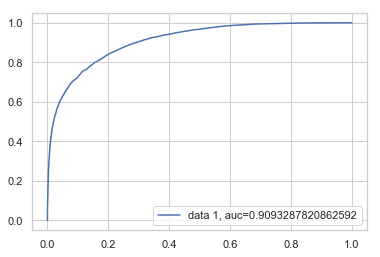

In [38]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)